#  <span style="color:orange">Style transfer - Exercise </span>

Welcome to this style transfer excercise. If you haven't followed the tutorial yet, we recommend that you do the tutorial first before completing this excercise. This is an exercise to get familiar with tool for image segmentation and style transfer. 

# 1 Objectives

The goal of this exercise is to create the most beautiful painting by customizing it with the style transfer. 

## Install useful packages

In [29]:
!printf 'pillow \nnumpy \ntorch==1.8.0 \ntorchvision==0.9.0 \nscipy \ntqdm \nmatplotlib \nipykernel \nazureml-core \nazureml-dataprep \nazure-cli' > requirements.txt

In [30]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 140 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.


## Connect to Azure Blob

In [ ]:
!az login

In [ ]:
!git clone https://github.com/datarootsio/workshop-image-segmentation-style-transfer.git

In [1]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config('./workshop-image-segmentation-style-transfer/config.json')
default_ds = ws.get_default_datastore()
print('Ready to use Azure ML {} to work with {} (datastore = {})'.format(
        azureml.core.VERSION, ws.name,default_ds.name))
ds = ws.datasets['all']
mount_ds = ds.mount()
ds_mount_folder = mount_ds.mount_point

DATA_DIR = ds_mount_folder
print("You have access to the Azure Blob!")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Ready to use Azure ML 1.42.0 to work with ml-homedesign (datastore = images_data)
Volume mount is not enabled. 
Falling back to dataflow mount.
You have access to the Azure Blob!


In [2]:
mount_ds.start()

# 2 Choose the image to custom

In [4]:
from google.colab import files

uploaded = files.upload()
uploaded_image = list(uploaded.keys())[0]

Saving paint.jpg to paint.jpg


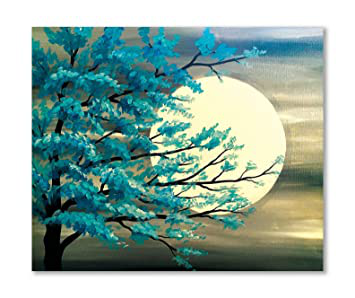

In [11]:
from PIL import Image
from IPython.display import display

img = Image.open(uploaded_image)
display(img)

# 3 Choose the pattern to apply to the image

## Load pattern from Azure

In [15]:
# Get style example from Azure 
import os

styles = {
    "multi-color": "examples/multicolor_pattern.jpeg",
    "tiger": "examples/tiger_pattern.jpeg",
    "water": "examples/water_pattern.jpeg",
    "zebra": "examples/zebra_pattern.jpeg",
}

pattern = "tiger"
style_path = os.path.join(DATA_DIR, styles[pattern])
img = Image.open(style_path)
img.save(f"{pattern}.jpg")

## Upload pattern locally

In [18]:
from google.colab import files

uploaded = files.upload()

style_path = list(uploaded.keys())[0]

Saving multicolor_pattern.jpeg to multicolor_pattern.jpeg


## Resize the pattern image chosen and display it

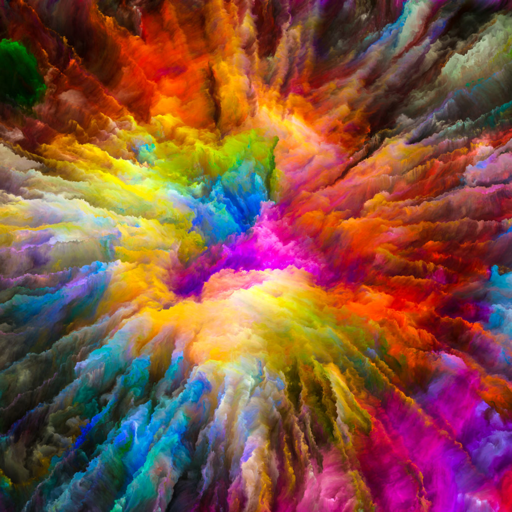

In [19]:
from PIL import Image
from IPython.display import display
import numpy as np

img = Image.open(style_path)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (512, 512)
im1 = img.crop((left, top, right, bottom))
im1 = im1.resize(newsize)
display(im1)

## Customize your pattern

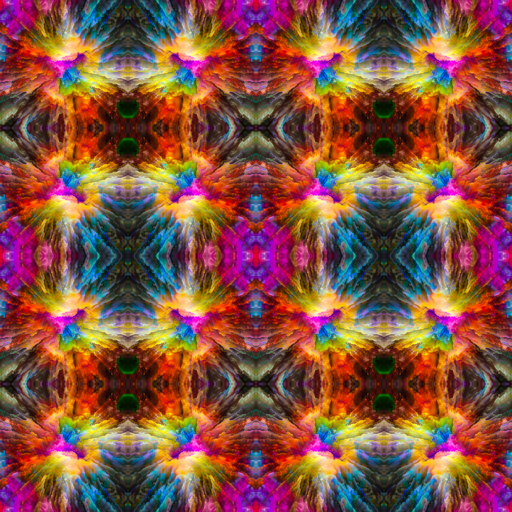

In [22]:
copies = 4
resize = (newsize[0]//copies,newsize[1]//copies)
dst = Image.new('RGB', (resize[0]*copies,resize[1]*copies))
im2 = im1.resize((resize))
for row in range(copies):
  im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
  for column in range(copies):
    im2 = im2.transpose(Image.FLIP_TOP_BOTTOM)
    dst.paste(im2, (resize[0]*row, resize[1]*column))
dst = dst.resize((newsize))
dst.save('./style_customized.jpg')
display(dst)

# 4 Apply the pattern on the entire image

In [23]:
!git clone https://github.com/diyiiyiii/StyTR-2.git

Cloning into 'StyTR-2'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 83 (delta 10), reused 9 (delta 9), pack-reused 69
Unpacking objects: 100% (83/83), done.


In [6]:
# Get pre-trained model from the cloud
import os 
vgg_path = os.path.join(DATA_DIR, "models/vgg_normalised.pth")
decoder_path = os.path.join(DATA_DIR, "models/decoder_iter_160000.pth")
transformer_path = os.path.join(DATA_DIR, "models/transformer_iter_160000.pth")
embedding_path = os.path.join(DATA_DIR, "models/embedding_iter_160000.pth")
uploaded_image = "paint.jpg"

In [7]:
!python StyTR-2/test.py  --content $uploaded_image \
                  --style style_customized.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

paint.jpg
<class 'int'>
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


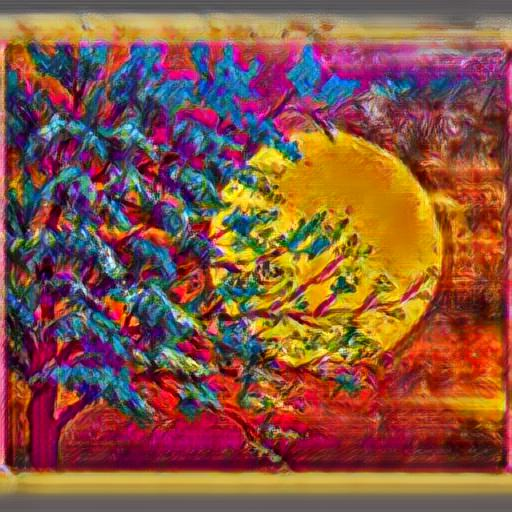

In [9]:
# Let's look at the styled image
from IPython.display import Image, display
path_styled_image = uploaded_image.split(".")[0] + "_stylized_style_customized.jpg"
display(Image(filename=path_styled_image))

# 5 Get final customized image

## Get the mask of the object we want to custom 

## Apply style only on the chosen object